## 1. Import dataset & data preprocess

See details in utils/data_preprocess.ipynb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Example input images:


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


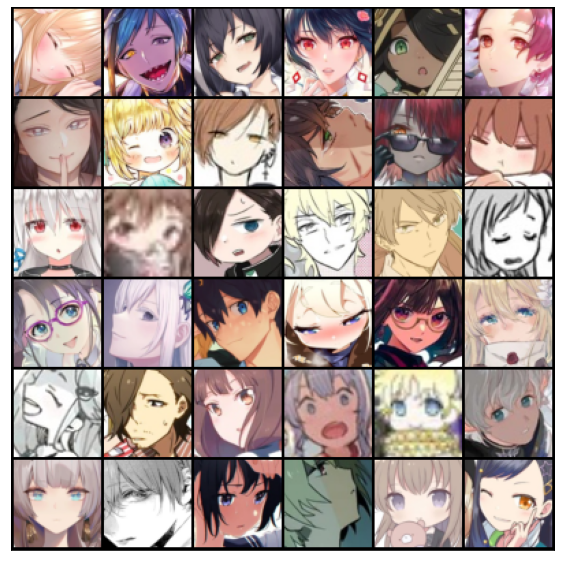

In [3]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/data_preprocess.ipynb

## 2. Load DCGAN base architecture


In [4]:
!pip install torchsummary
import torch.nn as nn
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Inputs for the run:
# Number of workers for dataloader
workers = 2
batch_size = 128
image_size = 64
nc = 3    # Number of channels in the training images. For color images this is 3
latent_size = 128  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
epochs = 50
lr = 0.0002
betas = (0.5, 0.999)
ngpu = 1  # Number of GPUs available. Use 0 for CPU mode.
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # in: latent_size x 1 x 1
            #512 = ngf * 8
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
generator = Generator()
discriminator = Discriminator()

torch.Size([128, 3, 64, 64])


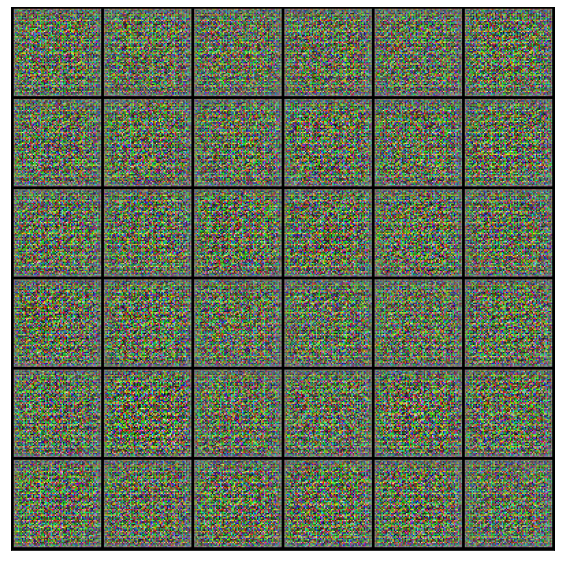

In [11]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_img)

In [13]:
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

In [14]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of generator:' + color.END)

print(summary(generator,(latent_size,1,1)))

Architecture of generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
            

In [15]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of discriminator:' + color.END)
print(summary(discriminator,(3,64,64)))

Architecture of discriminator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
        

## Train DCGAN


In [16]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torch.autograd import Variable

In [17]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [18]:
sample_dir = 'generated_dcgan/images'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = '{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [19]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving 0000.png


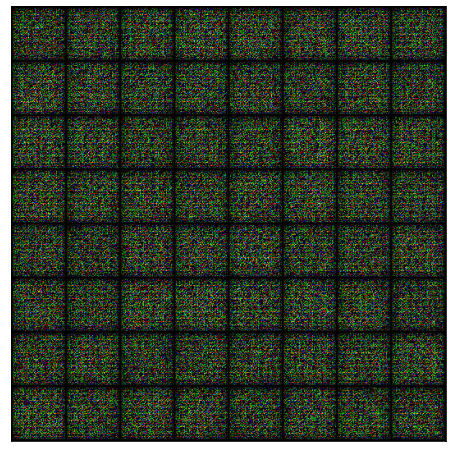

In [20]:
save_samples(0, fixed_latent)

In [21]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            # Train discriminator
            # Clear discriminator gradients
            optimizer_D.zero_grad()

            # Pass real images through discriminator
            real_preds = discriminator(real_images)
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)
            fake_preds = discriminator(fake_images)

            real_targets = torch.ones(real_images.size(0), 1, device=device)
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)

            real_loss = F.binary_cross_entropy(real_preds, real_targets)
            real_score = torch.mean(real_preds).item()
            fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
            fake_score = torch.mean(fake_preds).item()

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()

            optimizer_D.step()
            loss_d = loss_d.item()


            # Clear generator gradients
            optimizer_G.zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)
            
            # Try to fool the discriminator
            preds = discriminator(fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = F.binary_cross_entropy(preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer_G.step()

            loss_g = loss_g.item()
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/757 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 5.1495, loss_d: 0.4740, real_score: 0.8622, fake_score: 0.2457
Saving 0001.png


  0%|          | 0/757 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 14.0682, loss_d: 3.4108, real_score: 0.9991, fake_score: 0.9363
Saving 0002.png


  0%|          | 0/757 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 3.6256, loss_d: 0.1703, real_score: 0.9054, fake_score: 0.0571
Saving 0003.png


  0%|          | 0/757 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 5.6865, loss_d: 0.0809, real_score: 0.9564, fake_score: 0.0310
Saving 0004.png


  0%|          | 0/757 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 7.4945, loss_d: 0.2436, real_score: 0.9798, fake_score: 0.1835
Saving 0005.png


  0%|          | 0/757 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 10.3532, loss_d: 0.4926, real_score: 0.9950, fake_score: 0.2686
Saving 0006.png


  0%|          | 0/757 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 11.9249, loss_d: 0.1749, real_score: 0.9723, fake_score: 0.0782
Saving 0007.png


  0%|          | 0/757 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 5.9043, loss_d: 0.0877, real_score: 0.9768, fake_score: 0.0588
Saving 0008.png


  0%|          | 0/757 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 3.4089, loss_d: 0.1396, real_score: 0.9074, fake_score: 0.0155
Saving 0009.png


  0%|          | 0/757 [00:00<?, ?it/s]

In [31]:
losses_g_dcgan, losses_d_dcgan, real_scores_dcgan, fake_scores_dcgan = history

In [32]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

## Output visualization & evaluation


In [33]:
output_dir = '/content/generated_dcgan'

In [1]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/visualize_outputs.ipynb

NameError: ignored

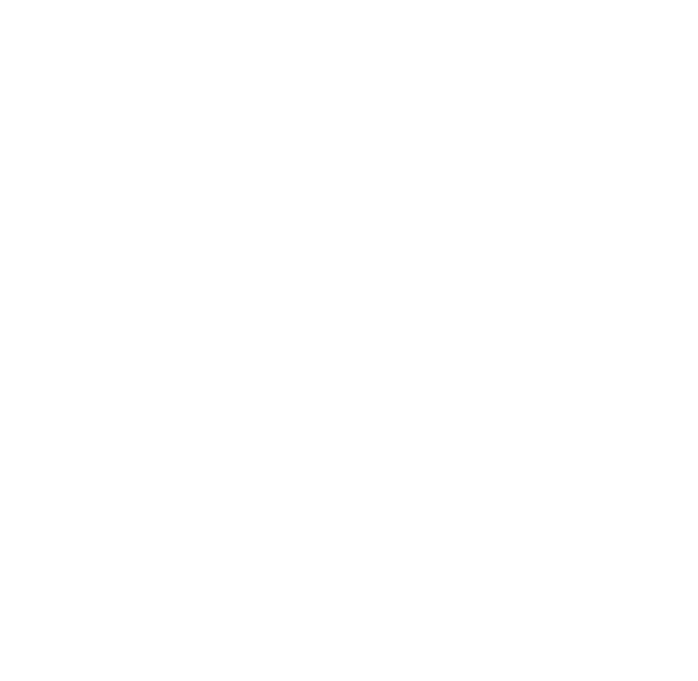

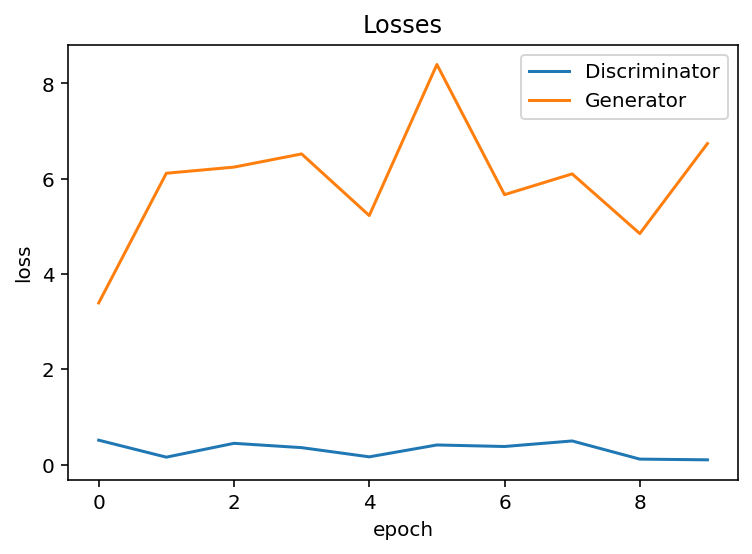

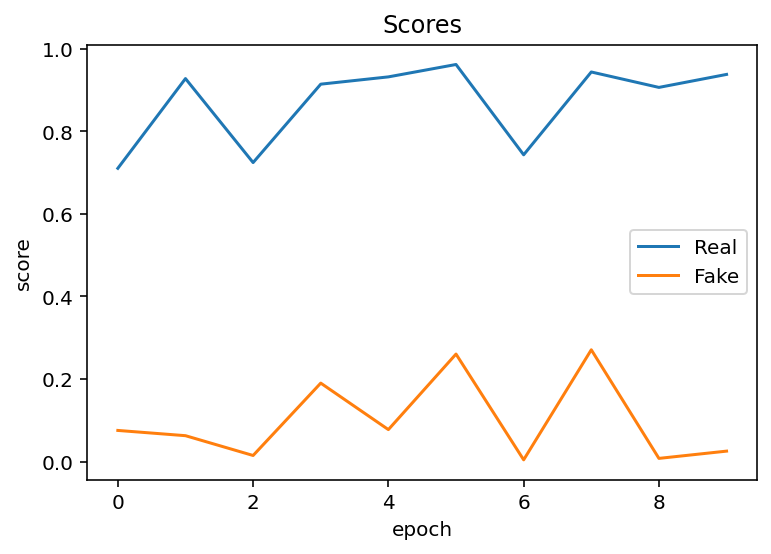

In [35]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/eval.ipynb